In [1]:
import cfe
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

[2025年01月16日 12时57分19秒] INFO                                                                                 
                                          _____     _ _ ______    _       ______            _                      
                                         / ____|   | | |  ____|  | |     |  ____|          | |                     
                                        | |     ___| | | |__ __ _| |_ ___| |__  __  ___ __ | | ___  _ __ ___ _ __  
                                        | |    / _ \ | |  __/ _` | __/ _ \  __| \ \/ / '_ \| |/ _ \| '__/ _ \ '__| 
                                        | |___|  __/ | | | | (_| | ||  __/ |____ >  <| |_) | | (_) | | |  __/ |    
                                         \_____\___|_|_|_|  \__,_|\__\___|______/_/\_\ .__/|_|\___/|_|  \___|_|    
                                                                                     | |                           
                                                                              

## 1. 构造数据并绘制拓扑图

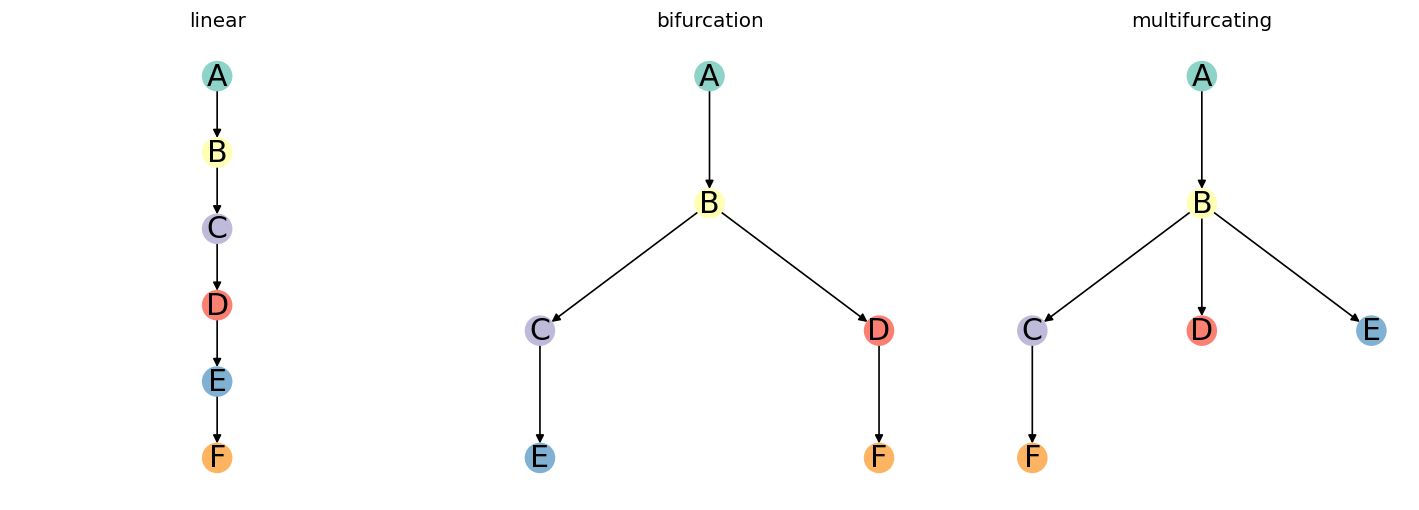

In [2]:
# 导入数据
milestone_netowrk_dict = cfe.data.topologies_with_same_n_milestones

# 封装轨迹
fadata_dict = {}
for id, milestone_netowrk in milestone_netowrk_dict.items():
    fadata = cfe.data.generate_trajectory(milestone_netowrk, id)
    fadata_dict[id] = fadata


# 可视化
n = len(fadata_dict)
fig, ax = plt.subplots(1, n, figsize=(n * 5, 5), dpi=120)
i = 0
for id, trajectory in fadata_dict.items():
    cfe.plot.plot_topology(trajectory, ax=ax[i], nx_draw_kwrags={"font_size": 18})
    ax[i].set_title(id)
    i += 1

In [3]:
# 合并到同一个 FateAnnData上
main_model_name = "linear"
fadata_merge = fadata_dict[main_model_name]

for model_name, fadata in fadata_dict.items():
    fadata_merge.trajectory_history_dict[model_name] = fadata.trajectory_history_dict["default"]


del fadata_merge.trajectory_history_dict["default"]
fadata_merge.model_name = main_model_name

model_name_list = fadata_merge.get_all_model_name()
model_name_list

                        WARNING  'linear' is not a valid random_time_string, don't need parse                      
                        WARNING  'bifurcation' is not a valid random_time_string, don't need parse                 
                        WARNING  'multifurcating' is not a valid random_time_string, don't need parse              


['linear', 'bifurcation', 'multifurcating']

## 2. 模型交叉，指标计算并可视化

In [4]:
metrics = cfe.metric.metrics
metric_id_list = metrics[metrics["category"] == "topology"]["metric_id"].tolist()

metrics_result_dict = {}
for model_name1 in model_name_list:
    for model_name2 in model_name_list:
        model_metric = cfe.metric.calculate_metrics(
            fadata_merge,
            metrics=metric_id_list,
            now_model=model_name1,
            ref_model=model_name2
        )
        metrics_result_dict[(model_name1, model_name2)] = model_metric

metrics_result_dict

{('linear', 'linear'): {'isomorphic': 1, 'edge_flip': 0, 'him': 0},
 ('linear', 'bifurcation'): {'isomorphic': 0, 'edge_flip': 0, 'him': 0},
 ('linear', 'multifurcating'): {'isomorphic': 0, 'edge_flip': 0, 'him': 0},
 ('bifurcation', 'linear'): {'isomorphic': 0, 'edge_flip': 0, 'him': 0},
 ('bifurcation', 'bifurcation'): {'isomorphic': 1, 'edge_flip': 0, 'him': 0},
 ('bifurcation', 'multifurcating'): {'isomorphic': 0,
  'edge_flip': 0,
  'him': 0},
 ('multifurcating', 'linear'): {'isomorphic': 0, 'edge_flip': 0, 'him': 0},
 ('multifurcating', 'bifurcation'): {'isomorphic': 0,
  'edge_flip': 0,
  'him': 0},
 ('multifurcating', 'multifurcating'): {'isomorphic': 1,
  'edge_flip': 0,
  'him': 0}}

可视化

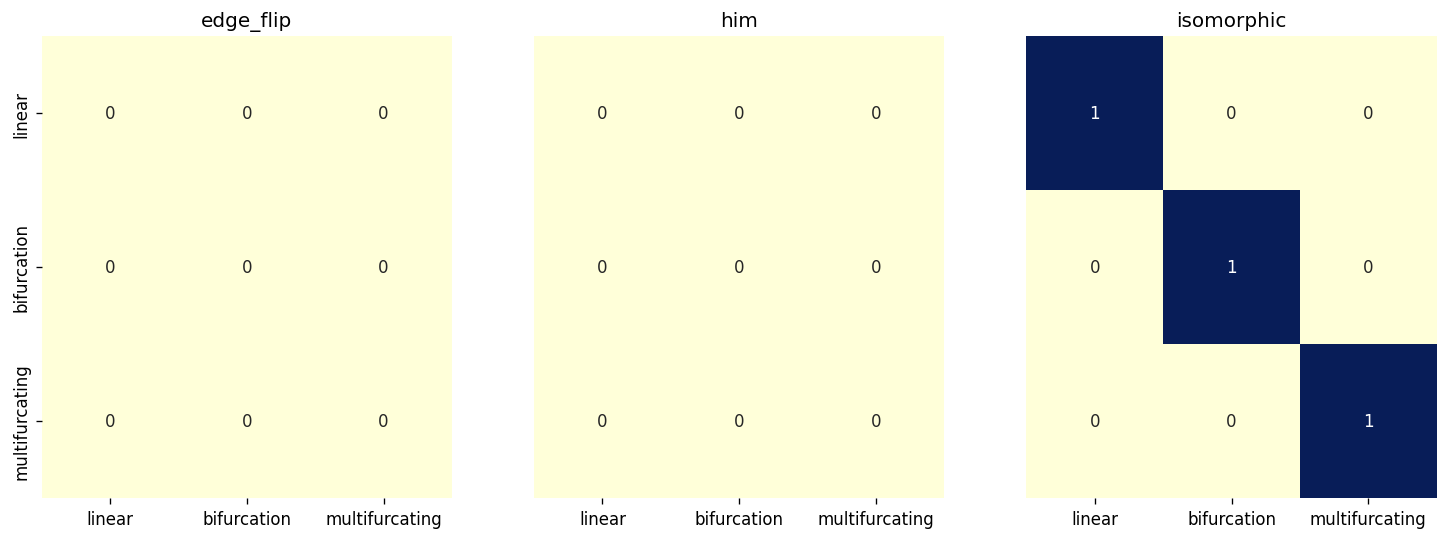

In [5]:
# 构建空dataframe
metric_dataframe_dict = {}
for metric_id in metric_id_list:
    metric_dataframe_dict[metric_id] = pd.DataFrame(columns=model_name_list, index=model_name_list, dtype="float")


# 填充dataframe
for trajectory_id_tuple in metrics_result_dict.keys():
    trajectory_id1, trajectory_id2 = trajectory_id_tuple
    for metric_id in metric_id_list:
        metric_dataframe_dict[metric_id].loc[trajectory_id1, trajectory_id2] = metrics_result_dict[trajectory_id_tuple][metric_id]

# 可视化dataframe
n = len(metric_id_list)
fig, ax = plt.subplots(1, n, figsize=(n * 5, 5), dpi=120)
i = 0
for metric_id in metric_id_list:
    sns.heatmap(metric_dataframe_dict[metric_id], ax=ax[i], annot=True, cmap="YlGnBu", cbar=False)
    if not i == 0:
        ax[i].set_yticks([])
    ax[i].set_title(metric_id)
    i += 1

## 3. 细微干扰测试，调整边长

In [6]:
# 细微干扰数据基于milestone_network
topology = pd.DataFrame(
    data=[
        ["A", "B"],
        ["B", "D"],
        ["B", "C"],
        ["D", "E"],
        ["D", "F"],
    ],
    columns=["from", "to"]
)
# 在DE，DE边上延长
new_length_list = [0, 0.05, 0.5, 1]
milestone_netowrk_dict = {}
for new_length in new_length_list:
    milestone_netowrk = topology.copy()
    milestone_netowrk["directed "] = True
    milestone_netowrk["length"] = 1
    milestone_netowrk.loc[milestone_netowrk.apply(lambda x: x["from"]=="D", axis=1), "length"] = new_length
    milestone_netowrk = milestone_netowrk[milestone_netowrk["length"] !=0] # 过滤为0的边
    milestone_netowrk_dict[new_length] = milestone_netowrk

milestone_netowrk_dict

{0:   from to  directed   length
 0    A  B       True       1
 1    B  D       True       1
 2    B  C       True       1,
 0.05:   from to  directed   length
 0    A  B       True    1.00
 1    B  D       True    1.00
 2    B  C       True    1.00
 3    D  E       True    0.05
 4    D  F       True    0.05,
 0.5:   from to  directed   length
 0    A  B       True     1.0
 1    B  D       True     1.0
 2    B  C       True     1.0
 3    D  E       True     0.5
 4    D  F       True     0.5,
 1:   from to  directed   length
 0    A  B       True       1
 1    B  D       True       1
 2    B  C       True       1
 3    D  E       True       1
 4    D  F       True       1}

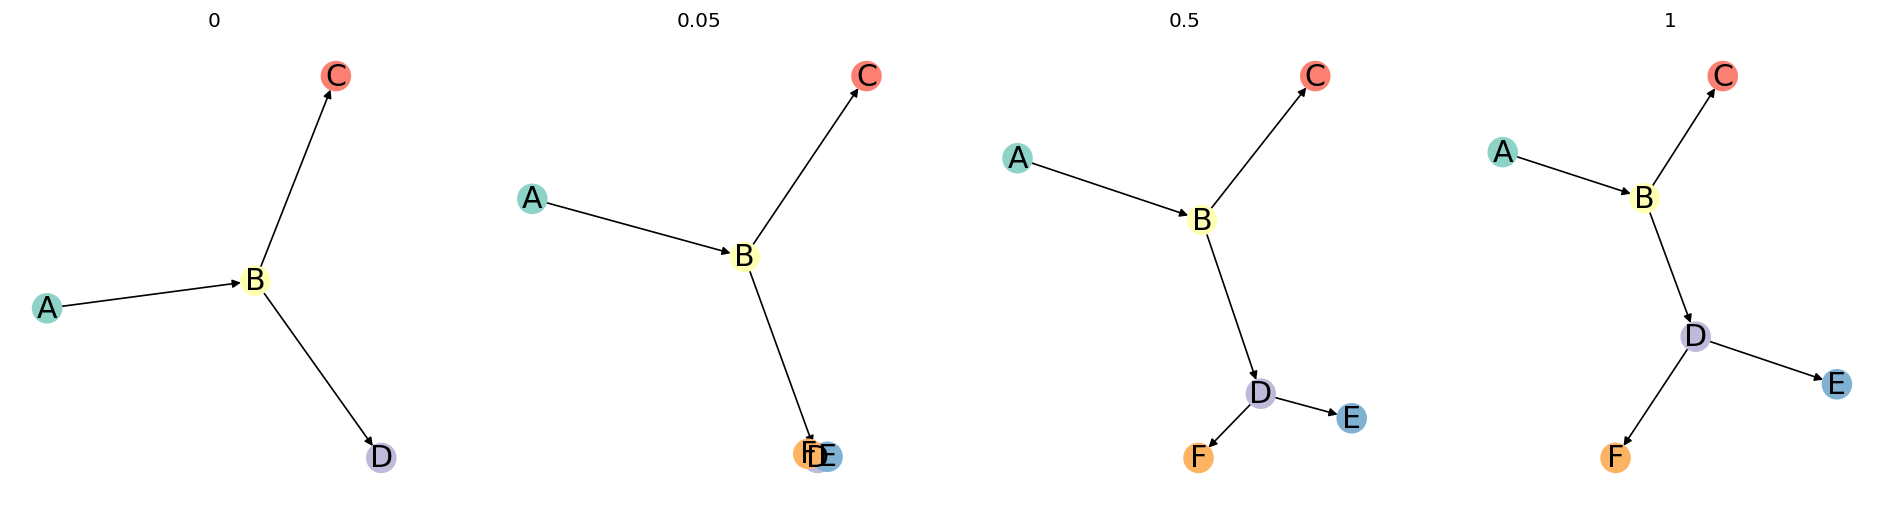

In [7]:
# 构造轨迹
fadata_dict = {}
for id, milestone_netowrk in milestone_netowrk_dict.items():
    trajectory = cfe.data.generate_trajectory(milestone_netowrk, id)
    fadata_dict[id] = trajectory

# 可视化
n = len(fadata_dict)
fig, ax = plt.subplots(1, n, figsize=(n * 5, 5), dpi=120)
i = 0
for id, trajectory in fadata_dict.items():
    cfe.plot.plot_topology(trajectory, ax=ax[i], nx_draw_kwrags={"font_size": 18}, layout="neato")
    ax[i].set_title(id)
    i += 1

In [8]:
# 合并到同一个 FateAnnData上
main_model_name = 0
fadata_merge = fadata_dict[main_model_name]

for model_name, fadata in fadata_dict.items():
    model_name = str(model_name) # 转化为数字
    fadata_merge.trajectory_history_dict[model_name] = fadata.trajectory_history_dict["default"]


del fadata_merge.trajectory_history_dict["default"]
fadata_merge.model_name = str(main_model_name)

model_name_list = fadata_merge.get_all_model_name()
model_name_list

[2025年01月16日 12时57分20秒] WARNING  '0' is not a valid random_time_string, don't need parse                     
                        WARNING  '0.05' is not a valid random_time_string, don't need parse                        
                        WARNING  '0.5' is not a valid random_time_string, don't need parse                         
                        WARNING  '1' is not a valid random_time_string, don't need parse                           


['0', '0.05', '0.5', '1']

In [9]:
metrics_result_dict = {}
for model_name in model_name_list:
    model_metric = cfe.metric.calculate_metrics(
        fadata_merge,
        metrics=metric_id_list,
        now_model=model_name,
        ref_model="0"
    )
    metrics_result_dict[model_name] = model_metric

metric_result_df = pd.DataFrame(metrics_result_dict)
metric_result_df

,0,0.05,0.5,1
isomorphic,1,0,0,0
edge_flip,0,0,0,0
him,0,0,0,0
